# Apply Regression to anchors

In this notebook, we are going to take an image sample containing a ground truth box an trying to generate anchors across the image, retrieve the positive anchors and regress them so the perfectly fit the ground truth box.

Around this example, we will be able to build a complex object detection training pipeline without much effort. 

In [1]:
import sys
import json

from PIL import Image
import matplotlib.pyplot as plt

import jax
import jax.numpy as np

sys.path.append('..')
import anchors_jax as aj

## Load image and its annotations

In [2]:
im = Image.open('../images/umbreon.png')
annot = json.load(open('../images/umbreon.json', 'r'))

Since the annotations are generated with the [labelme](https://github.com/wkentaro/labelme) software, we can retrive the ground truth boxes from the `shape` property.

In [3]:
annot['shapes']

[{'label': 'umbreon',
  'points': [[346.75757575757575, 90.96969696969697],
   [878.5757575757575, 624.3030303030303]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}}]

In [4]:
boxes = [sum(o['points'], []) for o in annot['shapes']]
boxes = np.array(boxes).astype('int32')
boxes

/home/gnom/miniconda3/envs/jax/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray([[346,  90, 878, 624]], dtype=int32)

In [5]:
def show_im(im, title):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(im)
    plt.axis('off')

def legend(labels, colors):
    from matplotlib.lines import Line2D
    line_colors = [Line2D([0], [0], color=c, lw=4) for c in colors]
    plt.legend(line_colors, labels)

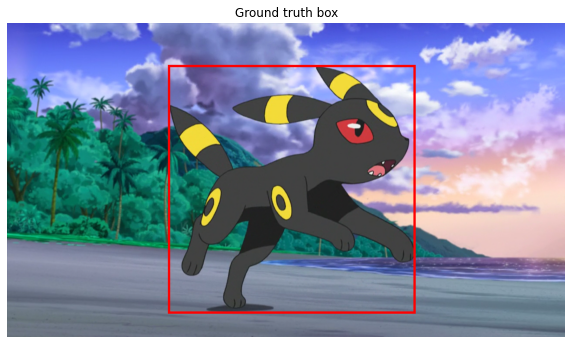

In [6]:
gt_im = aj.viz.draw_boxes(im, boxes, boxes_width=5, 
                          colors=aj.viz.Color.Red)

show_im(gt_im, 'Ground truth box');

We can see how the box tightly wraps the Umbreon

## Generate anchors

Usually the anchors, are generated at each location of a single or multiple feature maps, in this example, we are going to generate the anchors using the *input* image.

In [7]:
anchors = aj.faster_rcnn.generate_anchors(im.size[::-1], stride=10)
anchors = anchors.reshape(-1, 4)

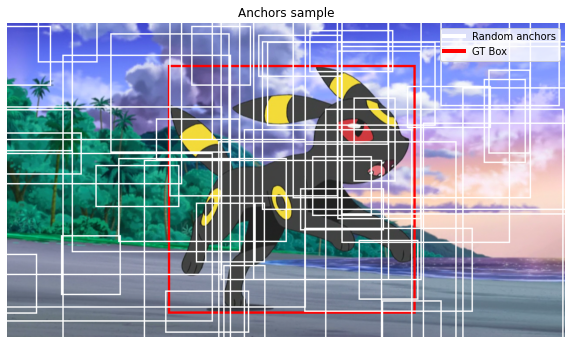

In [8]:
rng = jax.random.PRNGKey(0)
key, subkey = jax.random.split(rng)
rand_idx = jax.random.randint(minval=0, maxval=anchors.shape[0], shape=(50,), key=subkey)

rand_achors_im = aj.viz.draw_boxes(gt_im, anchors[rand_idx], boxes_width=3)
show_im(rand_achors_im, 'Anchors sample')
legend(['Random anchors', 'GT Box'], ['#ffffff', aj.viz.Color.Red])

## Labeling anchors

In the previous image, we can see how some anchors are pretty close to the actuall ground truth box and some other are really far away. To train a supervised model to being able to learn how to regress the anchors, we have to assign an objectness score and a regression to each anchor.

The objectness score (labels) contains a 1 if the anchor is pretty close to the ground truth box, a 0 if it is far from the box and a -1 if the anchor is ambigious (can confuse the model). To perform classification on anchors we ignore the -1 values and when applying regression we only one to compute the regression for positive anchors, therefore we only apply regression when the objectess score is 1.

In [9]:
labels, regressors = aj.faster_rcnn.rpn_tag_anchors(anchors, boxes)
true_mask = labels.reshape(-1) == 1.
false_mask = labels.reshape(-1) == 0.
ambigious_mask = labels.reshape(-1) == -1

true_anchors = anchors[true_mask]
false_anchors = anchors[false_mask]
ambigious_anchors = anchors[ambigious_mask]

true_regressors = regressors[true_mask]

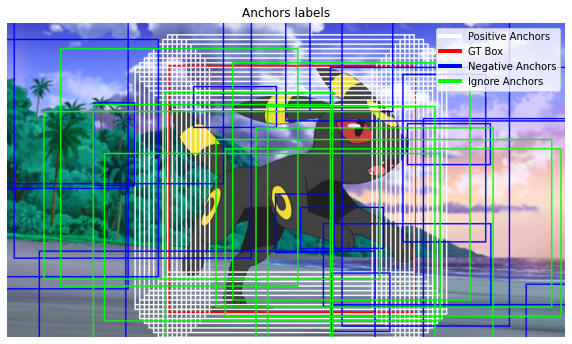

In [23]:
anchors_im = aj.viz.draw_boxes(gt_im, anchors[true_mask], boxes_width=3)

key, false_key, ignore_key = jax.random.split(subkey, 3)

false_rand_idx = jax.random.randint(minval=0, maxval=false_anchors.shape[0], 
                                    shape=(20,), key=false_key)

ignore_rand_idx = jax.random.randint(minval=0, maxval=ambigious_anchors.shape[0], 
                                     shape=(10,), key=ignore_key)

anchors_im = aj.viz.draw_boxes(anchors_im, false_anchors[false_rand_idx], 
                               boxes_width=3, colors=aj.viz.Color.Blue)

anchors_im = aj.viz.draw_boxes(anchors_im, ambigious_anchors[ignore_rand_idx], 
                               boxes_width=3, colors=aj.viz.Color.Green)

show_im(anchors_im, 'Anchors labels')
legend(['Positive Anchors', 'GT Box', 'Negative Anchors', 'Ignore Anchors'], 
       ['#ffffff', aj.viz.Color.Red, aj.viz.Color.Blue, aj.viz.Color.Green])

## Regress the positive anchors

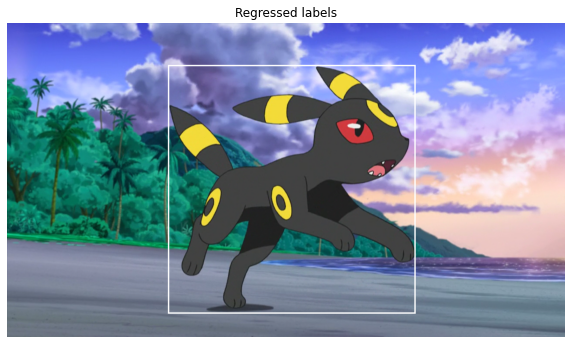

In [24]:
regressed_anchors = aj.faster_rcnn.apply_regressors(true_anchors, true_regressors)
show_im(aj.viz.draw_boxes(im, regressed_anchors, boxes_width=3), 'Regressed labels')